# Business Case Analysis: Unsupervised Learning

In this business case analysis I am using an online retail store dataset found in the [Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Online+Retail). The aim of this dataset is to identify models of purchases across the time. I will perform in this dataset:
- Artificial intelligence and natural language processing to identify category concepts given descriptions. Meaning identify the overall concept of a description given its content.
- Apply unsuperviser Learning to find groups of purchases.
- Apply ARIMA model to predict sells in a given period of time. 

In [1]:
import pandas as pd
from pandas import ExcelFile
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sys
from pandas.plotting import autocorrelation_plot
import warnings
import statsmodels.api as sm
import seaborn as sns

In [2]:
data_original = pd.read_csv('Online Retail.csv')

In [3]:
data_original

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09/12/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09/12/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09/12/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09/12/2011 12:50,4.15,12680.0,France


# Descriptive Analytics

In [4]:
data_invoice = data_original[['InvoiceNo','Quantity','UnitPrice']]

In [5]:
# Get attributes per Invoice
grp_invoice = data_invoice.groupby(['InvoiceNo']).sum()

In [6]:
grp_invoice.columns = ['Quantity','UnitPrice']

### Quantity analysis

In [7]:
grp_invoice['Quantity']

InvoiceNo
536365        40
536366        12
536367        83
536368        15
536369         3
           ...  
C581484   -80995
C581490      -23
C581499       -1
C581568       -5
C581569       -6
Name: Quantity, Length: 25900, dtype: int64

In [8]:
#Invoice with the biggest amount of articles
grp_invoice['Quantity'].max()

80995

In [9]:
#Invoice with the less amount of articles
grp_invoice['Quantity'].min()

-80995

<AxesSubplot:>

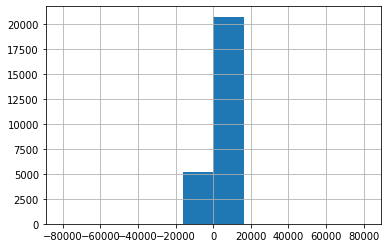

In [10]:
#Invoice quantity distribution, it seems to have a tendency of a normal distribution.
grp_invoice['Quantity'].hist()

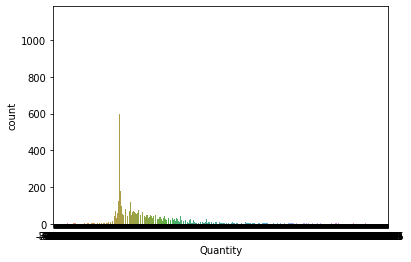

In [11]:
ax = sns.countplot(x="Quantity",data=grp_invoice)

In [12]:
#standard deviation
grp_invoice['Quantity'].std()

1108.5635509560302

In [13]:
#mean
grp_invoice['Quantity'].mean()

199.86293436293437

In [14]:
#median
grp_invoice['Quantity'].median()

100.0

In [15]:
#q1
grp_invoice['Quantity'].quantile(0.25)

6.0

In [16]:
#q3
grp_invoice['Quantity'].quantile(0.75)

240.0

In [17]:
#IQR 
grp_invoice['Quantity'].quantile(0.75) - grp_invoice['Quantity'].quantile(0.25)

234.0

### UnitPrice Analysis

In [18]:
grp_invoice['UnitPrice']

InvoiceNo
536365      27.37
536366       3.70
536367      58.24
536368      19.10
536369       5.95
            ...  
C581484      2.08
C581490      2.78
C581499    224.69
C581568     10.95
C581569      2.50
Name: UnitPrice, Length: 25900, dtype: float64

In [19]:
grp_invoice['UnitPrice'].min()

-11062.06

In [20]:
grp_invoice['UnitPrice'].max()

38970.0

<AxesSubplot:>

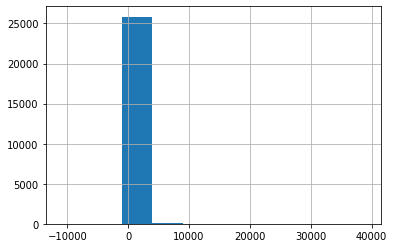

In [21]:
grp_invoice['UnitPrice'].hist()

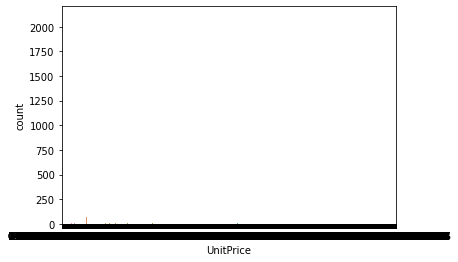

In [22]:
ax = sns.countplot(x="UnitPrice",data=grp_invoice)

In [23]:
#standard deviation
grp_invoice['UnitPrice'].std()

494.6777865091785

In [24]:
#unit price mean
grp_invoice['UnitPrice'].mean()

96.47891791505793

In [25]:
#unit price median
grp_invoice['UnitPrice'].median()

31.13

In [26]:
#q1
grp_invoice['UnitPrice'].quantile(0.25)

7.41

In [27]:
#q3
grp_invoice['UnitPrice'].quantile(0.75)

75.665

In [28]:
#iqr
grp_invoice['UnitPrice'].quantile(0.75) - grp_invoice['UnitPrice'].quantile(0.25)

68.25500000000001

### Customer id analysis amount of purchases

In [29]:
customer_purchase = data_original[['CustomerID','UnitPrice']]

In [30]:
customer_purchase

,CustomerID,UnitPrice
0,17850.0,2.55
1,17850.0,3.39
2,17850.0,2.75
3,17850.0,3.39
4,17850.0,3.39
...,...,...
541904,12680.0,0.85
541905,12680.0,2.10
541906,12680.0,4.15
541907,12680.0,4.15


In [31]:
#count the number of purchases per customer
number_purchases_per_customer = customer_purchase['CustomerID'].value_counts()

In [32]:
number_purchases_per_customer

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
13391.0       1
16579.0       1
13366.0       1
17763.0       1
17846.0       1
Name: CustomerID, Length: 4372, dtype: int64

In [33]:
#Purchase with the maximum amount of money.

print(f'customer number_purchases {number_purchases_per_customer.max()}')

customer number_purchases 7983


In [34]:
#Purchase with the minimum amount of money.

print(f'customer number_purchases {number_purchases_per_customer.min()}')

customer number_purchases 1


In [35]:
#Purchases standard deviation of purchases.
number_purchases_per_customer.std()

232.4716077416496

In [36]:
#Purchases mean.
number_purchases_per_customer.mean()

93.05329368709972

In [37]:
#Purchases median.
number_purchases_per_customer.median()

42.0

In [38]:
#Purchases q1.
number_purchases_per_customer.quantile(0.25)

17.0

In [39]:
#Purchases q3.
number_purchases_per_customer.quantile(0.75)

102.0

In [40]:
#iqr amount of purchases
number_purchases_per_customer.quantile(0.75) - number_purchases_per_customer.quantile(0.25)

85.0

<AxesSubplot:>

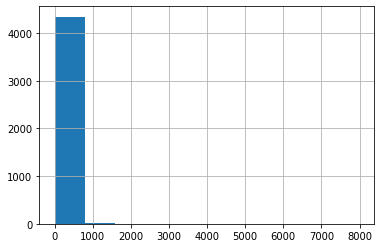

In [41]:
#looks like a skewed distribution to the left the amount of purchases made by each customer.
number_purchases_per_customer.hist()

 ### Customer id analysis amount of money spent in purchases

In [42]:
customer_spent = customer_purchase.groupby('CustomerID').agg(sum)

In [43]:
customer_spent.columns = ['UnitPrice']

In [44]:
customer_spent

,UnitPrice
CustomerID,
12346.0,2.08
12347.0,481.21
12348.0,178.71
12349.0,605.10
12350.0,65.30
...,...
18280.0,47.65
18281.0,39.36
18282.0,62.68


<AxesSubplot:>

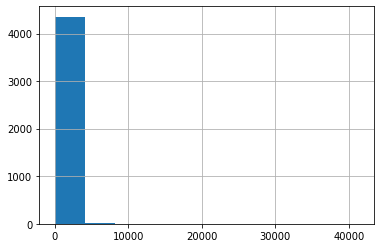

In [45]:
#amount of money spent per customer distribution. It has a skewed distribution to the left.
customer_spent['UnitPrice'].hist()

In [46]:
#The highest amount of money spent per customer.
customer_spent[customer_spent['UnitPrice'] == customer_spent['UnitPrice'].max()]

,UnitPrice
CustomerID,
14096.0,41376.33


In [47]:
#The least amount of money spent per customer.
customer_spent[customer_spent['UnitPrice'] == customer_spent['UnitPrice'].min()]

,UnitPrice
CustomerID,
13256.0,0.0


In [48]:
#the standard deviation
customer_spent['UnitPrice'].std()

1284.7830979985495

In [80]:
#the mean
customer_spent['UnitPrice'].mean()

322.008225983532

In [81]:
#the median
customer_spent['UnitPrice'].median()

130.095

In [49]:
#q1
customer_spent['UnitPrice'].quantile(0.25)

52.86500000000001

In [50]:
#q3
customer_spent['UnitPrice'].quantile(0.75)

302.3324999999999

In [51]:
#iqr
customer_spent['UnitPrice'].quantile(0.75) - customer_spent['UnitPrice'].quantile(0.25)

249.46749999999992

### Purchases per Country Analysis

In [52]:
data_country = data_original[['Country','Quantity','UnitPrice']]

In [53]:
#How many different countries do I have?
data_country['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [54]:
len(data_country['Country'].unique())

38

In [55]:
#What is the total amount of money per country?
data_country_sum = data_original[['Country','UnitPrice']].groupby('Country').agg(sum)

In [56]:
data_country_sum

,UnitPrice
Country,
Australia,4.054750e+03
Austria,1.701520e+03
Bahrain,8.657000e+01
Belgium,7.540130e+03
Brazil,1.426000e+02
Canada,9.105800e+02
Channel Islands,3.738550e+03
Cyprus,3.920070e+03
Czech Republic,8.815000e+01


In [57]:
#Which is the country with more sales?
data_country_sum[data_country_sum['UnitPrice'] == data_country_sum['UnitPrice'].max()]

,UnitPrice
Country,
United Kingdom,2.245715e+06


In [58]:
#Which is the country with less sales?
data_country_sum[data_country_sum['UnitPrice'] == data_country_sum['UnitPrice'].min()]

,UnitPrice
Country,
Saudi Arabia,24.11


<AxesSubplot:>

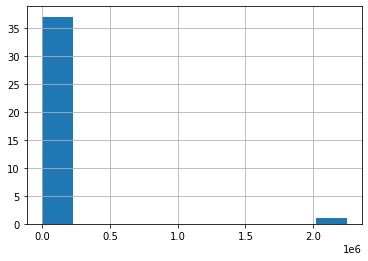

In [59]:
#How is the distribution of my total sales? Skewed to the left.
data_country_sum['UnitPrice'].hist()

In [60]:
#Total sales std
data_country_sum['UnitPrice'].std()

363389.75350306573

In [61]:
#Total sales mean
data_country_sum['UnitPrice'].mean()

65757.99931566422

In [62]:
#Total sales median
data_country_sum['UnitPrice'].median()

1561.8950000000027

In [63]:
#Total sales q1
data_country_sum['UnitPrice'].quantile(0.25)

522.1525

In [64]:
#Total sales q3
data_country_sum['UnitPrice'].quantile(0.75)

6742.532499999955

In [65]:
#Total sales iqr
data_country_sum['UnitPrice'].quantile(0.75) - data_country_sum['UnitPrice'].quantile(0.25)

6220.379999999955

In [66]:
#What is the average amount of money per country?
data_country_avg = data_original[['Country','UnitPrice']].groupby('Country').agg(np.mean)

In [67]:
data_country_avg

,UnitPrice
Country,
Australia,3.220612
Austria,4.243192
Bahrain,4.556316
Belgium,3.644335
Brazil,4.456250
Canada,6.030331
Channel Islands,4.932124
Cyprus,6.302363
Czech Republic,2.938333


In [68]:
#Which is the country with more average in sales?
data_country_avg[data_country_avg['UnitPrice'] == data_country_avg['UnitPrice'].max()]

,UnitPrice
Country,
Singapore,109.645808


In [69]:
#Which is the country with less average in sales?
data_country_avg[data_country_avg['UnitPrice'] == data_country_avg['UnitPrice'].min()]

,UnitPrice
Country,
USA,2.216426


<AxesSubplot:>

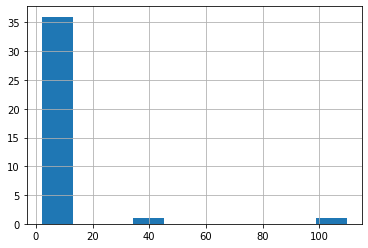

In [70]:
#How is the distribution of my average sales? Skewed to the left.
data_country_avg['UnitPrice'].hist()

In [71]:
#Total sales std
data_country_avg['UnitPrice'].std()

18.07487741314582

In [72]:
#Total sales mean
data_country_avg['UnitPrice'].mean()

8.051961196151037

In [73]:
#Total sales median
data_country_avg['UnitPrice'].median()

4.366918103448276

In [74]:
#Total sales q1
data_country_avg['UnitPrice'].quantile(0.25)

3.2878894790564077

In [75]:
#Total sales q3
data_country_avg['UnitPrice'].quantile(0.75)

5.190345943230162

In [76]:
#Total sales iqr
data_country_avg['UnitPrice'].quantile(0.75) - data_country_avg['UnitPrice'].quantile(0.25)

1.9024564641737545

### Timestamp Analysis

In [77]:
data_original['InvoiceDate'].sort_values(ascending=False)

431672    31/10/2011 17:19
431671    31/10/2011 17:18
431670    31/10/2011 17:13
431669    31/10/2011 17:13
431668    31/10/2011 17:13
                ...       
77637     01/02/2011 08:23
77638     01/02/2011 08:23
77639     01/02/2011 08:23
77640     01/02/2011 08:23
77641     01/02/2011 08:23
Name: InvoiceDate, Length: 541909, dtype: object

In [78]:
#least timestamp
data_original['InvoiceDate'].min()

'01/02/2011 08:23'

In [79]:
#least timestamp
data_original['InvoiceDate'].max()

'31/10/2011 17:19'

### Descriptive Analytics Summary

From the descriptive analytics from above we can infer the next information:
	* The amount of times that the customer goes into the store/website and buy something is 93 in a 9 month period.
	* The average amount of money spent per customer each 9 months is 322.
	* The average amount of articles that each customer buys in a 9 month period is 199.
	* We have 38 countries in total.
	* The country with more total sales is United kingdom.
	* The country with less total sales is Saudi Arabia.
	* The country with the highest average sales is Singapore.
	* The country with the less average sales is USA.
	* We have 9 months total of data, this means that we are not able to really catch seasonallity effects, but perhaps a trend. The best is to have 2 year period of data to catch the seasonallity effect, but it might work with at least 1 year. Given the conditions, I decided to use prophet to do a forecast of next 3 months for United Kingdom and Singapura of the total amount of sales.
	* From the information above we can infer as well that United kingdom has a lot of good wholesale customers, because the mean and median are very far appart from each other. On the other hand Singapore has a lot of direct sales because the mean and the median are close to each other. 

# Apply Natural Language Processing

For this kind of task, I am going to need to implement a bag of words algorithm with a clustering technique over my descriptions to check how well my cluster fill in categories. The main idea is to identify categories over my products and been able to add more insights based on the purchases made per category.

In [ ]:
#TODO ADD NLP
#Todo try to implement a xgboost

# Time Series

In this case I am going to do a small forecast over my series with the overall sales per month. I am going to forecast the next 3 months of sales.

In [ ]:
#Todo add the time series